In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [221]:
X = np.arange(500).reshape(50, 10) * 1.0

theta = np.eye(10,10) * 1.0

def f(theta, X):
    out = X.dot(theta)
    return out

def divergence(f, theta_, X_):

    def my_div(f_):
        jac = jax.jacrev(f_, 1)
        return lambda t, x_: np.trace(jac(t, x_))

    div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
    return div
    
print(divergence(f, theta, X).shape)

(50,)


In [254]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
        self.b_backward_ = jax.vmap(self.b_backward, in_axes=(None, 0))
        self.b_forward_ = jax.vmap(self.b_forward, in_axes=(None, 0))
        
        self.b_backward_s =  lambda theta, x: np.squeeze(self.b_backward(x, theta))
        self.b_forward_s = lambda theta, x: np.squeeze(self.b_forward(x, theta))
        
        self.div_backward_ = jax.vmap(partial(self.divergence, self.b_backward), in_axes=(None, 0))
        self.div_forward_ = jax.vmap(partial(self.divergence, self.b_forward), in_axes=(None, 0))
        
    @staticmethod
    def divergence(f, theta_, X_):

        def my_div(f_):
            jac = jax.jacrev(f_, 1)
            return lambda t, x_: np.trace(jac(t, x_))

        div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
        return div
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward_(self.theta_b, Xt)
            b_plus = self.b_forward_(theta, Xt)
            div = self.div_backward_(self.theta_b, Xt)
        else:
            b_minus  = self.b_backward_(theta, Xt)
            b_plus = self.b_forward_(self.theta_f, Xt)
            div = -self.div_forward_(self.theta_f, Xt)
        
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(axis=(1,2)) - div.sum(axis=(1))
        
        if np.isnan(out).any() or np.isinf(out).any():
            import pdb; pdb.set_trace()
        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)
        
        if np.isnan(cross_entropy).any() or np.isnan(main_term).any():
            import pdb; pdb.set_trace()

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, batch_f, True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

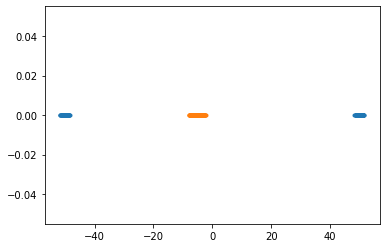

In [255]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) - 50
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [262]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=500 , step_size = 0.001, weights=[50,50,50,50])

In [264]:
c.fit(500,30)

loss b 25191.501953125
loss b 23899.337890625
loss b 22908.63671875
loss b 21862.7265625
loss b 20858.458984375
loss b 20035.2109375
loss b 19306.1015625
loss b 18617.748046875
loss b 18004.849609375
loss b 17408.037109375
loss b 16795.16796875
loss b 16188.77734375
loss b 15601.80078125
loss b 15066.5439453125
loss b 14486.220703125
loss b 13892.466796875
loss b 13301.0185546875
loss b 12804.03515625
loss b 12208.8896484375
loss b 11687.3310546875
loss b 11130.9248046875
loss b 10594.572265625
loss b 10092.77734375
loss b 9634.1748046875
loss b 9136.9345703125
loss b 8646.5205078125
loss b 8201.8408203125
loss b 7806.90625
loss b 7400.01806640625
loss b 7050.84619140625
loss f -64.43185424804688
loss f -65.02974700927734
loss f -65.44477844238281
loss f -66.06852722167969
loss f -66.40967559814453
loss f -67.15672302246094
loss f -67.52422332763672
loss f -68.07810974121094
loss f -68.75359344482422
loss f -69.35873413085938
loss f -70.03224182128906
loss f -70.67137908935547
loss f -

loss b 1423.987548828125
loss b 1423.1273193359375
loss b 1423.92236328125
loss b 1421.841064453125
loss b 1417.056884765625
loss f -181.08731079101562
loss f -181.10528564453125
loss f -181.17459106445312
loss f -181.10552978515625
loss f -181.1449737548828
loss f -181.10464477539062
loss f -181.11279296875
loss f -181.0984649658203
loss f -181.1221466064453
loss f -181.14736938476562
loss f -181.1207733154297
loss f -181.1148223876953
loss f -181.11123657226562
loss f -181.12911987304688
loss f -181.11077880859375
loss f -181.15692138671875
loss f -181.12310791015625
loss f -181.16470336914062
loss f -181.13055419921875
loss f -181.12985229492188
loss f -181.14537048339844
loss f -181.13331604003906
loss f -181.19094848632812
loss f -181.0659942626953
loss f -181.152587890625
loss f -181.11013793945312
loss f -181.1197967529297
loss f -181.1170654296875
loss f -181.15353393554688
loss f -181.1656036376953
loss b 1425.400146484375
loss b 1424.9959716796875
loss b 1421.802734375
loss b

loss f -187.97802734375
loss f -187.94009399414062
loss f -187.98069763183594
loss f -187.98439025878906
loss f -187.9496612548828
loss f -187.96682739257812
loss f -187.96192932128906
loss f -187.9893035888672
loss f -187.9712677001953
loss f -187.97288513183594
loss f -187.9730682373047
loss f -187.99314880371094
loss f -187.98233032226562
loss f -187.93443298339844
loss f -188.00787353515625
loss f -187.95346069335938
loss b 1428.2667236328125
loss b 1430.4490966796875
loss b 1426.265869140625
loss b 1435.5438232421875
loss b 1427.901123046875
loss b 1432.22705078125
loss b 1429.422119140625
loss b 1429.9141845703125
loss b 1428.3497314453125
loss b 1434.3511962890625
loss b 1428.7403564453125
loss b 1431.0093994140625
loss b 1428.0438232421875
loss b 1428.7943115234375
loss b 1427.698486328125
loss b 1431.140869140625
loss b 1429.4298095703125
loss b 1428.1231689453125
loss b 1423.693603515625
loss b 1431.4627685546875
loss b 1427.5810546875
loss b 1430.73974609375
loss b 1428.0833

loss b 1427.35009765625
loss b 1431.1617431640625
loss b 1428.7698974609375
loss b 1427.4483642578125
loss b 1426.967529296875
loss b 1426.1309814453125
loss b 1426.887939453125
loss b 1426.25439453125
loss b 1431.3310546875
loss b 1429.0380859375
loss b 1429.173583984375
loss b 1428.537841796875
loss b 1425.2584228515625
loss b 1431.6063232421875
loss b 1430.01904296875
loss b 1433.3260498046875
loss b 1426.4744873046875
loss b 1431.810791015625
loss b 1427.183837890625
loss b 1428.2633056640625
loss b 1429.267333984375
loss b 1425.5098876953125
loss b 1430.3309326171875
loss b 1425.845703125
loss b 1429.87451171875
loss b 1429.7138671875
loss b 1428.4552001953125
loss b 1425.997802734375
loss f -192.86703491210938
loss f -192.8515167236328
loss f -192.84474182128906
loss f -192.8548126220703
loss f -192.84579467773438
loss f -192.8525390625
loss f -192.86070251464844
loss f -192.84783935546875
loss f -192.85379028320312
loss f -192.87376403808594
loss f -192.8592071533203
loss f -192

loss b 1427.7569580078125
loss b 1428.5655517578125
loss b 1430.228515625
loss b 1425.3734130859375
loss b 1426.9754638671875
loss b 1425.0264892578125
loss b 1426.995849609375
loss b 1429.094970703125
loss b 1425.0306396484375
loss f -196.59901428222656
loss f -196.59564208984375
loss f -196.60023498535156
loss f -196.58963012695312
loss f -196.59085083007812
loss f -196.6038360595703
loss f -196.5878143310547
loss f -196.5926513671875
loss f -196.59725952148438
loss f -196.60362243652344
loss f -196.64346313476562
loss f -196.58348083496094
loss f -196.59596252441406
loss f -196.59170532226562
loss f -196.60025024414062
loss f -196.6065216064453
loss f -196.60317993164062
loss f -196.5944061279297
loss f -196.5821075439453
loss f -196.61375427246094
loss f -196.60531616210938
loss f -196.5963134765625
loss f -196.61221313476562
loss f -196.59718322753906
loss f -196.59681701660156
loss f -196.59983825683594
loss f -196.60922241210938
loss f -196.61416625976562
loss f -196.58705139160

loss f -200.46934509277344
loss f -200.46998596191406
loss f -200.48509216308594
loss f -200.4911651611328
loss f -200.48179626464844
loss f -200.48886108398438
loss f -200.4947509765625
loss f -200.50198364257812
loss f -200.49285888671875
loss f -200.48399353027344
loss f -200.46775817871094
loss f -200.46678161621094
loss f -200.4654083251953
loss f -200.48179626464844
loss f -200.4872589111328
loss f -200.48875427246094
loss f -200.4784698486328
loss f -200.47608947753906
loss f -200.49363708496094
loss f -200.495361328125
loss f -200.4821319580078
loss b 1426.4952392578125
loss b 1424.8720703125
loss b 1424.78076171875
loss b 1427.77880859375
loss b 1428.422119140625
loss b 1426.67822265625
loss b 1425.4195556640625
loss b 1430.8834228515625
loss b 1421.2684326171875
loss b 1422.9757080078125
loss b 1425.8218994140625
loss b 1424.5899658203125
loss b 1428.9180908203125
loss b 1426.337158203125
loss b 1424.9830322265625
loss b 1420.8782958984375
loss b 1423.737548828125
loss b 1425

loss f -204.4208984375
loss f -204.4237823486328
loss f -204.4224395751953
loss b 1423.0220947265625
loss b 1425.5811767578125
loss b 1425.245849609375
loss b 1420.331298828125
loss b 1419.1488037109375
loss b 1420.580810546875
loss b 1421.7991943359375
loss b 1421.1409912109375
loss b 1421.964599609375
loss b 1422.4501953125
loss b 1422.8802490234375
loss b 1418.6107177734375
loss b 1422.1422119140625
loss b 1420.0711669921875
loss b 1423.1104736328125
loss b 1420.6182861328125
loss b 1421.20068359375
loss b 1421.11669921875
loss b 1422.4110107421875
loss b 1424.0352783203125
loss b 1421.0462646484375
loss b 1418.314208984375
loss b 1422.134765625
loss b 1420.5567626953125
loss b 1422.57177734375
loss b 1421.7530517578125
loss b 1421.576416015625
loss b 1420.6971435546875
loss b 1420.8123779296875
loss b 1425.5655517578125
loss f -205.1943359375
loss f -205.218994140625
loss f -205.20013427734375
loss f -205.18978881835938
loss f -205.1949462890625
loss f -205.16600036621094
loss f -2

loss b 1419.33154296875
loss b 1418.1171875
loss b 1417.5054931640625
loss b 1421.4228515625
loss b 1421.4873046875
loss b 1411.4171142578125
loss b 1416.479736328125
loss b 1416.3616943359375
loss b 1417.02197265625
loss b 1418.293212890625
loss b 1415.5972900390625
loss b 1419.6263427734375
loss b 1415.0338134765625
loss b 1420.8292236328125
loss f -208.78536987304688
loss f -208.7615966796875
loss f -208.77835083007812
loss f -208.7797088623047
loss f -208.78958129882812
loss f -208.77572631835938
loss f -208.76559448242188
loss f -208.79319763183594
loss f -208.78347778320312
loss f -208.7928924560547
loss f -208.8001251220703
loss f -208.7948455810547
loss f -208.7867889404297
loss f -208.78028869628906
loss f -208.78118896484375
loss f -208.7836456298828
loss f -208.7730255126953
loss f -208.7769775390625
loss f -208.7786865234375
loss f -208.77127075195312
loss f -208.7783660888672
loss f -208.772705078125
loss f -208.78591918945312
loss f -208.78018188476562
loss f -208.7875366

loss f -211.81362915039062
loss f -211.81454467773438
loss f -211.82289123535156
loss f -211.8369140625
loss f -211.8114776611328
loss f -211.82521057128906
loss f -211.82534790039062
loss f -211.83987426757812
loss f -211.83941650390625
loss f -211.80618286132812
loss f -211.80551147460938
loss f -211.82028198242188
loss f -211.82479858398438
loss f -211.8178253173828
loss f -211.8177032470703
loss f -211.82518005371094
loss f -211.80679321289062
loss f -211.84422302246094
loss f -211.83424377441406
loss f -211.82266235351562
loss f -211.80636596679688
loss f -211.82220458984375
loss f -211.82199096679688
loss f -211.8262176513672
loss f -211.8236846923828
loss f -211.8281707763672
loss b 1407.1534423828125
loss b 1409.546630859375
loss b 1404.72900390625
loss b 1408.8133544921875
loss b 1407.2452392578125
loss b 1410.58203125
loss b 1404.3114013671875
loss b 1404.0587158203125
loss b 1411.748046875
loss b 1403.306640625
loss b 1410.324951171875
loss b 1409.39306640625
loss b 1404.998

loss f -214.72218322753906
loss f -214.7494354248047
loss f -214.7248992919922
loss f -214.7084197998047
loss f -214.7108154296875
loss f -214.72808837890625
loss f -214.7447052001953
loss f -214.70956420898438
loss b 1404.67041015625
loss b 1402.8912353515625
loss b 1404.36376953125
loss b 1403.0386962890625
loss b 1399.738525390625
loss b 1404.8841552734375
loss b 1397.8380126953125
loss b 1400.4600830078125
loss b 1402.44970703125
loss b 1405.2391357421875
loss b 1401.8720703125
loss b 1401.62353515625
loss b 1397.46435546875
loss b 1404.0047607421875
loss b 1395.995849609375
loss b 1401.0926513671875
loss b 1404.5450439453125
loss b 1405.7784423828125
loss b 1399.852783203125
loss b 1402.9840087890625
loss b 1401.0152587890625
loss b 1401.275390625
loss b 1399.6680908203125
loss b 1394.9490966796875
loss b 1395.124267578125
loss b 1397.513427734375
loss b 1401.5810546875
loss b 1400.4342041015625
loss b 1402.8165283203125
loss b 1403.1669921875
loss f -215.39210510253906
loss f -21

loss b 1392.19189453125
loss b 1391.1793212890625
loss b 1389.353271484375
loss b 1394.4560546875
loss b 1389.585205078125
loss b 1394.1627197265625
loss b 1393.5880126953125
loss b 1393.476806640625
loss b 1393.005859375
loss b 1391.028076171875
loss b 1394.4599609375
loss b 1390.5582275390625
loss b 1393.322021484375
loss b 1391.2779541015625
loss b 1399.4261474609375
loss b 1393.3575439453125
loss b 1393.737060546875
loss b 1391.356201171875
loss b 1392.553955078125
loss b 1393.0047607421875
loss f -218.32595825195312
loss f -218.37545776367188
loss f -218.3353271484375
loss f -218.33474731445312
loss f -218.34771728515625
loss f -218.3623046875
loss f -218.32920837402344
loss f -218.3822021484375
loss f -218.33689880371094
loss f -218.3444061279297
loss f -218.3456573486328
loss f -218.35504150390625
loss f -218.37481689453125
loss f -218.3258514404297
loss f -218.3925018310547
loss f -218.37542724609375
loss f -218.31036376953125
loss f -218.31008911132812
loss f -218.369415283203

loss f -220.46853637695312
loss f -220.43260192871094
loss f -220.40626525878906
loss f -220.44741821289062
loss f -220.37295532226562
loss f -220.48095703125
loss f -220.418701171875
loss f -220.45704650878906
loss f -220.44117736816406
loss f -220.39730834960938
loss f -220.43446350097656
loss f -220.44796752929688
loss f -220.48057556152344
loss f -220.42800903320312
loss f -220.3955535888672
loss f -220.38540649414062
loss f -220.45005798339844
loss f -220.421142578125
loss f -220.41629028320312
loss f -220.4432373046875
loss f -220.35678100585938
loss f -220.443359375
loss f -220.4532928466797
loss f -220.40296936035156
loss f -220.4117431640625
loss f -220.47067260742188
loss f -220.37423706054688
loss f -220.46754455566406
loss f -220.4270782470703
loss f -220.40538024902344
loss b 1381.94873046875
loss b 1377.9410400390625
loss b 1372.7784423828125
loss b 1373.161865234375
loss b 1379.91650390625
loss b 1379.851806640625
loss b 1373.8406982421875
loss b 1379.0076904296875
loss 

loss f -221.90185546875
loss f -221.93736267089844
loss f -221.9159698486328
loss f -221.90176391601562
loss f -221.91632080078125
loss f -221.93128967285156
loss f -221.83106994628906
loss f -221.94578552246094
loss f -221.919189453125
loss f -221.85379028320312
loss f -221.86192321777344
loss f -221.81298828125
loss b 1358.1739501953125
loss b 1353.24365234375
loss b 1354.6134033203125
loss b 1355.06787109375
loss b 1357.0936279296875
loss b 1358.4913330078125
loss b 1356.8914794921875
loss b 1362.8865966796875
loss b 1355.1424560546875
loss b 1358.10888671875
loss b 1358.87158203125
loss b 1353.726318359375
loss b 1355.5872802734375
loss b 1357.769287109375
loss b 1355.7132568359375
loss b 1355.093994140625
loss b 1357.6959228515625
loss b 1355.020263671875
loss b 1353.893798828125
loss b 1352.8883056640625
loss b 1360.5289306640625
loss b 1348.659912109375
loss b 1353.7872314453125
loss b 1353.106689453125
loss b 1352.9569091796875
loss b 1353.0699462890625
loss b 1352.856201171875

loss b 1329.22021484375
loss b 1329.7208251953125
loss b 1332.408447265625
loss b 1329.4210205078125
loss b 1328.964111328125
loss b 1328.756103515625
loss b 1325.8082275390625
loss b 1326.1942138671875
loss b 1331.0029296875
loss b 1330.3687744140625
loss b 1327.0279541015625
loss b 1331.54150390625
loss b 1326.1138916015625
loss b 1323.429931640625
loss b 1326.18505859375
loss b 1324.2288818359375
loss b 1327.5501708984375
loss b 1331.4884033203125
loss b 1327.3917236328125
loss b 1328.278564453125
loss b 1325.1715087890625
loss b 1325.6962890625
loss b 1323.979248046875
loss b 1324.315673828125
loss b 1325.9879150390625
loss f -222.8206329345703
loss f -222.80191040039062
loss f -222.92636108398438
loss f -222.93508911132812
loss f -222.855224609375
loss f -223.0485382080078
loss f -222.96853637695312
loss f -222.89208984375
loss f -222.7809600830078
loss f -223.01702880859375
loss f -222.98153686523438
loss f -222.84921264648438
loss f -222.92999267578125
loss f -222.87315368652344

loss b 1275.9190673828125
loss b 1279.6888427734375
loss b 1281.63037109375
loss b 1279.6556396484375
loss b 1284.6121826171875
loss b 1280.2222900390625
loss f -224.1502685546875
loss f -224.0069122314453
loss f -224.0264129638672
loss f -224.0121612548828
loss f -223.90435791015625
loss f -223.87921142578125
loss f -224.06887817382812
loss f -224.05801391601562
loss f -223.88265991210938
loss f -224.0872802734375
loss f -224.03709411621094
loss f -223.9504852294922
loss f -224.00782775878906
loss f -223.95492553710938
loss f -224.066650390625
loss f -224.00753784179688
loss f -224.04698181152344
loss f -223.9852752685547
loss f -224.14598083496094
loss f -224.10003662109375
loss f -223.97642517089844
loss f -224.10057067871094
loss f -224.23812866210938
loss f -224.00582885742188
loss f -223.97561645507812
loss f -223.97802734375
loss f -224.2181396484375
loss f -224.0555877685547
loss f -224.22242736816406
loss f -223.95596313476562
loss b 1275.2379150390625
loss b 1276.06103515625


loss f -225.40093994140625
loss f -225.43087768554688
loss f -225.4553985595703
loss f -225.39073181152344
loss f -225.2322540283203
loss f -225.3625030517578
loss f -225.301513671875
loss f -225.3450927734375
loss f -225.40362548828125
loss f -225.321044921875
loss f -225.5362091064453
loss f -225.263427734375
loss f -225.33273315429688
loss f -225.31619262695312
loss f -225.4734649658203
loss f -225.26316833496094
loss f -225.24346923828125
loss b 1239.798828125
loss b 1238.7213134765625
loss b 1239.716064453125
loss b 1238.0460205078125
loss b 1244.217041015625
loss b 1244.1505126953125
loss b 1242.287353515625
loss b 1242.946533203125
loss b 1247.19580078125
loss b 1244.477783203125
loss b 1238.4488525390625
loss b 1243.9088134765625
loss b 1243.1021728515625
loss b 1239.56787109375
loss b 1237.834716796875
loss b 1240.3763427734375
loss b 1243.56884765625
loss b 1239.62060546875
loss b 1235.658203125
loss b 1242.578125
loss b 1243.995849609375
loss b 1239.15625
loss b 1242.7124023

loss b 1233.9849853515625
loss b 1234.6103515625
loss b 1232.5032958984375
loss b 1233.1978759765625
loss b 1237.5703125
loss b 1228.85986328125
loss b 1231.47705078125
loss b 1235.8804931640625
loss b 1227.9700927734375
loss b 1231.711181640625
loss b 1230.2960205078125
loss b 1234.0548095703125
loss b 1234.8590087890625
loss b 1233.13330078125
loss b 1231.40478515625
loss b 1230.5750732421875
loss b 1236.0693359375
loss b 1231.2154541015625
loss b 1230.5010986328125
loss b 1232.38525390625
loss b 1231.736083984375
loss b 1228.3172607421875
loss b 1228.5286865234375
loss b 1230.6483154296875
loss b 1231.7530517578125
loss b 1226.828369140625
loss b 1232.16357421875
loss b 1227.888916015625
loss f -225.27667236328125
loss f -225.2505645751953
loss f -225.20693969726562
loss f -225.23126220703125
loss f -225.26226806640625
loss f -225.28985595703125
loss f -225.3231658935547
loss f -225.21165466308594
loss f -225.25564575195312
loss f -225.19302368164062
loss f -225.199951171875
loss f 

loss b 1231.25146484375
loss b 1228.820068359375
loss b 1229.8392333984375
loss b 1236.2010498046875
loss b 1229.3426513671875
loss b 1231.690673828125
loss b 1233.36572265625
loss b 1227.8740234375
loss b 1230.1834716796875
loss b 1229.0833740234375
loss b 1230.7698974609375
loss b 1229.2034912109375
loss b 1229.9229736328125
loss b 1228.3914794921875
loss b 1228.9737548828125
loss b 1229.871337890625
loss b 1229.904052734375
loss b 1230.0325927734375
loss b 1226.3670654296875
loss b 1229.3355712890625
loss b 1228.3297119140625
loss b 1232.9666748046875
loss b 1232.8487548828125
loss b 1230.330810546875
loss f -224.37391662597656
loss f -224.4569091796875
loss f -224.38255310058594
loss f -224.41403198242188
loss f -224.3483123779297
loss f -224.39024353027344
loss f -224.42918395996094
loss f -224.39486694335938
loss f -224.4152069091797
loss f -224.35452270507812
loss f -224.44464111328125
loss f -224.40078735351562
loss f -224.35125732421875
loss f -224.35049438476562
loss f -224.3

loss f -223.95826721191406
loss f -223.98388671875
loss f -223.9619140625
loss f -223.97434997558594
loss f -223.9368133544922
loss f -223.9574432373047
loss f -223.94564819335938
loss f -223.8976593017578
loss f -223.92662048339844
loss f -223.94842529296875
loss f -223.95816040039062
loss f -223.91375732421875
loss f -224.00343322753906
loss f -223.9693145751953
loss f -223.96009826660156
loss f -224.01304626464844
loss f -223.9954833984375
loss f -223.92236328125
loss f -223.9390411376953
loss f -223.93260192871094
loss f -223.9666290283203
loss f -224.00244140625
loss f -223.95266723632812
loss f -223.9414825439453
loss f -223.96949768066406
loss f -223.96774291992188
loss f -223.98023986816406
loss b 1230.98193359375
loss b 1228.960205078125
loss b 1232.3304443359375
loss b 1230.571533203125
loss b 1231.300048828125
loss b 1233.9730224609375
loss b 1230.9444580078125
loss b 1233.2982177734375
loss b 1229.4605712890625
loss b 1230.6368408203125
loss b 1230.024658203125
loss b 1232.

loss f -223.21066284179688
loss f -223.16114807128906
loss f -223.16912841796875
loss f -223.232177734375
loss f -223.13876342773438
loss f -223.14126586914062
loss f -223.16085815429688
loss f -223.08518981933594
loss f -223.1944580078125
loss b 1234.288330078125
loss b 1229.06884765625
loss b 1230.130126953125
loss b 1228.6502685546875
loss b 1230.9486083984375
loss b 1234.482666015625
loss b 1231.66259765625
loss b 1234.305908203125
loss b 1231.9505615234375
loss b 1231.937255859375
loss b 1232.5291748046875
loss b 1230.73828125
loss b 1225.96142578125
loss b 1233.43310546875
loss b 1230.4681396484375
loss b 1233.2373046875
loss b 1229.5152587890625
loss b 1232.93701171875
loss b 1226.156494140625
loss b 1232.4310302734375
loss b 1233.1947021484375
loss b 1229.21435546875
loss b 1232.62255859375
loss b 1230.205078125
loss b 1231.2176513671875
loss b 1233.9952392578125
loss b 1227.1331787109375
loss b 1230.9588623046875
loss b 1233.789306640625
loss b 1232.8675537109375
loss f -223.1

loss b 1234.40087890625
loss b 1230.862060546875
loss b 1235.9266357421875
loss b 1228.447265625
loss b 1227.7978515625
loss b 1230.7735595703125
loss b 1228.341552734375
loss b 1232.4251708984375
loss b 1232.441162109375
loss b 1229.2152099609375
loss b 1228.851318359375
loss b 1226.651123046875
loss b 1229.44384765625
loss b 1232.401123046875
loss b 1229.8359375
loss b 1231.59423828125
loss b 1233.873046875
loss b 1227.59423828125
loss b 1231.1336669921875
loss b 1232.623046875
loss f -222.69155883789062
loss f -222.67079162597656
loss f -222.6831817626953
loss f -222.67388916015625
loss f -222.6832275390625
loss f -222.66403198242188
loss f -222.67514038085938
loss f -222.66015625
loss f -222.69056701660156
loss f -222.7112274169922
loss f -222.7018585205078
loss f -222.64898681640625
loss f -222.64898681640625
loss f -222.65890502929688
loss f -222.68780517578125
loss f -222.679931640625
loss f -222.68450927734375
loss f -222.6560821533203
loss f -222.6560821533203
loss f -222.6811

loss b 1231.14794921875
loss f -222.08322143554688
loss f -222.0963897705078
loss f -222.08055114746094
loss f -222.07225036621094
loss f -222.12413024902344
loss f -222.1148223876953
loss f -222.0875244140625
loss f -222.06527709960938
loss f -222.10675048828125
loss f -222.08302307128906
loss f -222.0872039794922
loss f -222.0254669189453
loss f -222.08041381835938
loss f -222.12107849121094
loss f -222.07933044433594
loss f -222.0689239501953
loss f -222.0716552734375
loss f -222.0989990234375
loss f -222.07594299316406
loss f -222.06988525390625
loss f -222.10873413085938
loss f -222.08729553222656
loss f -222.0480194091797
loss f -222.08221435546875
loss f -222.06692504882812
loss f -222.0214080810547
loss f -222.1479034423828
loss f -222.06797790527344
loss f -222.0841827392578
loss f -222.10450744628906
loss b 1232.273193359375
loss b 1232.986083984375
loss b 1233.997314453125
loss b 1234.7486572265625
loss b 1233.7978515625
loss b 1231.0592041015625
loss b 1233.037109375
loss b

loss f -221.62474060058594
loss f -221.67453002929688
loss f -221.64862060546875
loss f -221.64175415039062
loss f -221.69422912597656
loss f -221.63507080078125
loss f -221.67092895507812
loss f -221.6510467529297
loss f -221.60792541503906
loss f -221.6122283935547
loss f -221.6177215576172
loss f -221.6282196044922
loss b 1232.193115234375
loss b 1231.6595458984375
loss b 1232.6649169921875
loss b 1235.197265625
loss b 1233.37646484375
loss b 1233.9373779296875
loss b 1235.141845703125
loss b 1233.2398681640625
loss b 1230.218017578125
loss b 1232.7362060546875
loss b 1230.0589599609375
loss b 1231.5460205078125
loss b 1233.9595947265625
loss b 1234.8779296875
loss b 1230.76171875
loss b 1232.126953125
loss b 1231.4166259765625
loss b 1234.88818359375
loss b 1235.0093994140625
loss b 1236.21484375
loss b 1234.144287109375
loss b 1232.5555419921875
loss b 1231.9698486328125
loss b 1237.1260986328125
loss b 1234.2940673828125
loss b 1231.8101806640625
loss b 1234.982666015625
loss b 1

loss b 1238.5369873046875
loss b 1233.3359375
loss b 1235.760498046875
loss b 1231.4820556640625
loss b 1236.574462890625
loss b 1230.8067626953125
loss b 1230.087158203125
loss b 1235.6346435546875
loss b 1230.97900390625
loss b 1232.0433349609375
loss b 1234.456787109375
loss b 1235.3907470703125
loss b 1233.6405029296875
loss b 1231.3162841796875
loss b 1236.0003662109375
loss b 1235.040283203125
loss b 1233.86767578125
loss b 1236.96240234375
loss b 1233.128173828125
loss b 1232.2928466796875
loss b 1232.9561767578125
loss b 1235.3070068359375
loss b 1235.0699462890625
loss b 1234.9124755859375
loss b 1229.739501953125
loss f -220.84507751464844
loss f -220.86953735351562
loss f -220.89894104003906
loss f -220.88633728027344
loss f -220.86749267578125
loss f -220.95455932617188
loss f -220.98182678222656
loss f -220.9036407470703
loss f -220.92233276367188
loss f -220.9064483642578
loss f -220.86770629882812
loss f -220.86476135253906
loss f -220.9304962158203
loss f -220.873794555

loss b 1234.1806640625
loss b 1233.8057861328125
loss b 1234.5560302734375
loss b 1233.1751708984375
loss b 1235.517578125
loss b 1233.4541015625
loss f -220.31692504882812
loss f -220.32167053222656
loss f -220.29270935058594
loss f -220.3178253173828
loss f -220.3522491455078
loss f -220.37997436523438
loss f -220.27401733398438
loss f -220.39205932617188
loss f -220.3238067626953
loss f -220.280029296875
loss f -220.35728454589844
loss f -220.32728576660156
loss f -220.3118438720703
loss f -220.31106567382812
loss f -220.3304443359375
loss f -220.33392333984375
loss f -220.3275146484375
loss f -220.3553009033203
loss f -220.3231964111328
loss f -220.31129455566406
loss f -220.2744140625
loss f -220.2165069580078
loss f -220.29425048828125
loss f -220.3734893798828
loss f -220.39617919921875
loss f -220.2762908935547
loss f -220.27471923828125
loss f -220.221923828125
loss f -220.34877014160156
loss f -220.26556396484375
loss b 1234.7266845703125
loss b 1234.5472412109375
loss b 1235

loss f -220.1442108154297
loss f -220.12289428710938
loss f -220.180419921875
loss f -220.0956573486328
loss f -220.19920349121094
loss f -220.0888671875
loss f -220.14154052734375
loss f -220.130859375
loss f -220.11985778808594
loss f -220.0828857421875
loss f -220.16908264160156
loss f -220.16384887695312
loss f -220.05459594726562
loss f -220.0952606201172
loss f -220.14801025390625
loss f -220.0642547607422
loss b 1235.20947265625
loss b 1239.03076171875
loss b 1234.540283203125
loss b 1238.083984375
loss b 1239.1671142578125
loss b 1240.9495849609375
loss b 1235.3232421875
loss b 1239.2645263671875
loss b 1235.19873046875
loss b 1239.2227783203125
loss b 1236.802978515625
loss b 1236.6968994140625
loss b 1234.61474609375
loss b 1233.6805419921875
loss b 1233.6243896484375
loss b 1239.2122802734375
loss b 1233.9224853515625
loss b 1237.338623046875
loss b 1239.9156494140625
loss b 1237.6778564453125
loss b 1235.5447998046875
loss b 1233.0220947265625
loss b 1239.2078857421875
loss

loss b 1236.965087890625
loss b 1239.974853515625
loss b 1236.4774169921875
loss b 1238.260009765625
loss b 1237.5069580078125
loss b 1238.5164794921875
loss b 1237.8746337890625
loss b 1237.6361083984375
loss b 1237.04345703125
loss b 1237.1761474609375
loss b 1238.6357421875
loss b 1237.155029296875
loss b 1235.6549072265625
loss b 1238.061767578125
loss b 1240.878173828125
loss b 1234.1650390625
loss b 1236.0780029296875
loss b 1234.80712890625
loss b 1237.5367431640625
loss b 1239.48193359375
loss b 1239.2144775390625
loss b 1238.3505859375
loss b 1236.9488525390625
loss b 1234.5589599609375
loss b 1236.97998046875
loss b 1236.201416015625
loss b 1238.8951416015625
loss f -220.03085327148438
loss f -219.98916625976562
loss f -219.9938507080078
loss f -219.93670654296875
loss f -220.01341247558594
loss f -220.0322265625
loss f -219.99862670898438
loss f -220.05316162109375
loss f -220.01416015625
loss f -219.99246215820312
loss f -220.06845092773438
loss f -220.0089569091797
loss f 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss b 1254.9527587890625
loss b 1255.2564697265625
loss b 1256.4832763671875
loss b 1256.6712646484375
loss b 1256.1649169921875
loss b 1254.7696533203125
loss b 1253.4459228515625
loss b 1253.277099609375
loss b 1254.28662109375
loss b 1250.230224609375
loss b 1258.444091796875
loss b 1255.7672119140625
loss b 1255.536376953125
loss b 1257.635986328125
loss b 1252.541748046875
loss b 1252.4515380859375
loss f -212.49668884277344
loss f -212.60975646972656
loss f -212.57363891601562
loss f -212.58236694335938
loss f -212.5355682373047
loss f -212.5191192626953
loss f -212.650146484375
loss f -212.58236694335938
loss f -212.59017944335938
loss f -212.57308959960938
loss f -212.5685272216797
loss f -212.6390838623047
loss f -212.57623291015625
loss f -212.62222290039062
loss f -212.6437225341797
loss f -212.57655334472656
loss f -212.54513549804688
loss f -212.61549377441406
loss f -212.5666046142578
loss f -212.52658081054688
loss f -212.56866455078125
loss f -212.51339721679688
loss f

loss f -212.4025115966797
loss f -212.51560974121094
loss f -212.47796630859375
loss f -212.45578002929688
loss f -212.4495086669922
loss f -212.47579956054688
loss f -212.4943084716797
loss f -212.46380615234375
loss f -212.48379516601562
loss f -212.50808715820312
loss f -212.50729370117188
loss f -212.45840454101562
loss f -212.4986572265625
loss f -212.48924255371094
loss f -212.45785522460938
loss f -212.46240234375
loss f -212.4464569091797
loss f -212.5338592529297
loss f -212.4915771484375
loss f -212.50889587402344
loss f -212.41392517089844
loss f -212.48643493652344
loss f -212.46934509277344
loss f -212.40524291992188
loss f -212.48431396484375
loss f -212.51271057128906
loss f -212.4619903564453
loss f -212.47789001464844
loss f -212.50518798828125
loss b 1262.8822021484375
loss b 1256.743896484375
loss b 1256.4498291015625
loss b 1258.4949951171875
loss b 1252.0738525390625
loss b 1261.596923828125
loss b 1258.5989990234375
loss b 1255.92236328125
loss b 1256.175659179687

KeyboardInterrupt: 

In [ ]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

In [ ]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [ ]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [ ]:
batch_terminal_empirical_b = next(c.data_stream(False))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")